## Recidivism Factor Analysis

This part contains the analysis of different factors, including personal features such as sex, age, race and marital status, COMPAS assessment result such as decile score of recidivism, charge degree and supervision level. 

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

sns.set(style="whitegrid")

conn = sqlite3.connect('./data/compas.db')
c = conn.cursor()
people = pd.read_sql_query("SELECT * FROM people", conn)
compas = pd.read_sql_query("SELECT * FROM compas", conn)

/Users/diegowongsiu/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
factor = people[['id','age', 'race', 'sex', 'c_charge_degree', 'decile_score', 'is_recid']].set_index('id')
recid_compas = compas[compas['type_of_assessment']=='Risk of Recidivism'].set_index('person_id')
recid_compas = recid_compas[['marital_status', 'rec_supervision_level']]
factor = factor.join(recid_compas, how='inner')
factor.head()

,age,race,sex,c_charge_degree,decile_score,is_recid,marital_status,rec_supervision_level
1,69,Other,Male,(F3),1,0,Single,1
2,31,Caucasian,Male,None,5,-1,Single,1
3,34,African-American,Male,(F3),3,1,Single,1
4,24,African-American,Male,(F3),4,1,Single,1
5,23,African-American,Male,(F3),8,0,Single,3


### 1. Correlation of factors

One important fact we can observe is that decile score is highly correlated with rec_supervision_level and therefore, we can only analyze one of them to get similar result. Hence, only decile score will be investigate in section 2. 

In [3]:
factor[['age', 'race', 'sex', 'marital_status', 'rec_supervision_level', 'c_charge_degree', 'decile_score']].corr()

,age,rec_supervision_level,decile_score
age,1.000000,-0.326173,-0.382505
rec_supervision_level,-0.326173,1.000000,0.877359
decile_score,-0.382505,0.877359,1.000000


### 2. Personal Features
#### 2.1 Sex

From the plot and calculation below, the data contains 80% male and 20% female, which roughly indicates the common situation that the male commits more crime. As for the rate of recidivism, the male group still have a slight higher rate than the female, and will be tested its significance at section 3. 

In [4]:
# Filter out factor with no recidivism data
factor = factor[factor['is_recid'] != -1]

is_recid          0          1
sex                           
Female    14.570774   5.400357
Male      49.240044  30.788826


<AxesSubplot:xlabel='sex'>

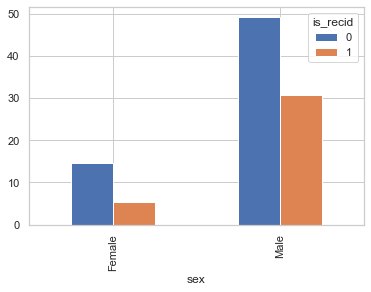

In [5]:
### The following code shows the percentage of recidivism categorized by sex
percentage = (pd.pivot_table(data = factor[['sex', 'is_recid']], index = 'sex', columns = 'is_recid', aggfunc = len, fill_value = 0)/len(factor)).mul(100)
print(percentage)
percentage.plot(kind = 'bar')

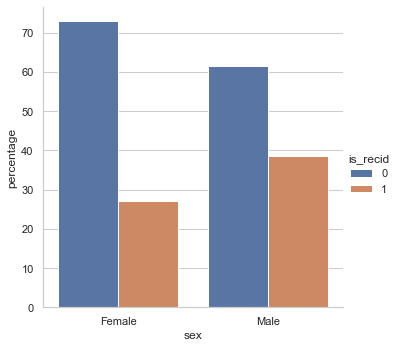

In [6]:
### The following code shows the percentage within each group
percentage = factor[['sex', 'is_recid']].groupby('sex')['is_recid'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.catplot(data=percentage, x = 'sex', kind = 'bar', y = 'percentage', hue = 'is_recid')

#### 2.2 age

In this part, the age will be grouped into 8 categories, under 18, 19-23, 24-30, 31-35, 36-40, 41-45, 46-50, and over 50, for the reason that under 18 are teenagers, 19-23 are the age for college students, 24-30 are still young adults, and the rest of them are categorized into a class every five years old.

First, we can see that only 0.02% of the factor are under 18, which may indicates that the database does not contain much of the data of teenagers, could be out of the reason to protect them. Therefore, the rest of the analysis are focused on adults. 

From the first plot in this part, people from 24 to 30 commit significantly most crime in this database, and the effect does not happened because of the way of categorization, for which 6 years of the people are included in this group. Also, as the age grows after 30, the number of crimes and recidivism keeps decreasing, until the last group, over 50 year old, which still contains a great number of people and could be re-categorized for further analysis. 

Now we can turn to the second plot. One important observation is that the rate of recidivist keeps decreasing from 43% to 23%, when the individuals are over 40. A possible reason is that the young tend to be more aggressive and less rational, or may be there are more life time for them to make mistake again after punishment or prison. Another guess is that the elder learn more from the first crime and become either aware of the criminal behavior or harder to be caught. 

Since the about 50% of the people lies under 35, we can set 35 as the threshold and make a hypothesis that people under 35 have a higher rate than that over 35 on recidivism and test it in section 3. 

In [7]:
factor['age_group'] = pd.cut(factor['age'], bins = [0, 18, 23, 30, 35, 40, 45, 50, 200], labels = ['under 18', '19-23', '24-30', '31-35', '36-40', '41-45', '46-50', 'over 50'])

is_recid           0          1
age_group                      
under 18    0.050947   0.025473
19-23       8.805298   7.803346
24-30      17.194532  12.498939
31-35       9.594973   5.383374
36-40       7.191984   3.184173
41-45       5.723019   2.258640
46-50       4.814469   1.885030
over 50    10.435595   3.150208


<AxesSubplot:xlabel='age_group'>

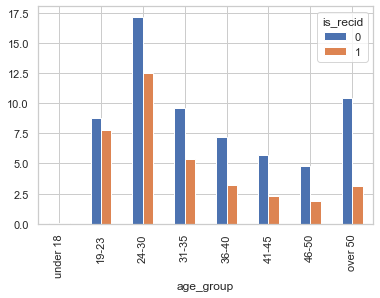

In [8]:
percentage = (pd.pivot_table(data = factor[['age_group', 'is_recid']], index = 'age_group', columns = 'is_recid', aggfunc = len, fill_value = 0)/len(factor)).mul(100)
print(percentage)
percentage.plot(kind = 'bar')

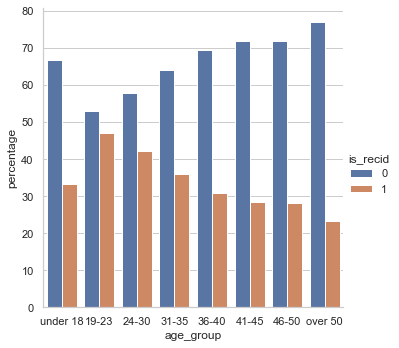

In [9]:
percentage = factor[['age_group', 'is_recid']].groupby('age_group')['is_recid'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.catplot(data=percentage, x = 'age_group', kind = 'bar', y = 'percentage', hue = 'is_recid')

#### 2.3 Marital status

The single dominates the dataset with 78% of the criminals, which is consistent to the result of the age where less young people get married and more criminals come from them. The result also indicate that the single is one of the significant factor that affect criminal behavior.

Although the effect of marital status on recidivism does not appear to be that significant as on criminal behavior, 40% of the single recidivated in this dataset while others have a revidivism rate for lower than 30%, excecpt for the one have significant other. Nevertheless, the one with significant other could not be concluded that they are another significant factor for recidivism, and is worth for further investigation. 

Later in section 2, the single will be tested for its significance on being recidivism. 

<AxesSubplot:>

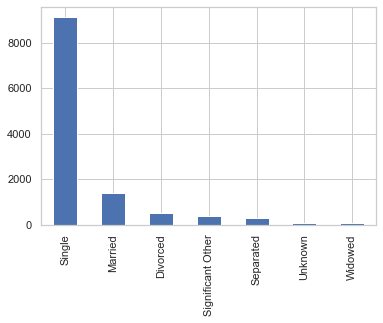

In [10]:
factor['marital_status'].value_counts().plot(kind = 'bar')

is_recid                   0          1
marital_status                         
Divorced            3.192664   0.993462
Married             8.907192   2.836036
Separated           1.783137   0.679290
Significant Other   1.995415   1.222722
Single             47.176700  30.194447
Unknown             0.407574   0.152840
Widowed             0.348136   0.110385


<AxesSubplot:xlabel='marital_status'>

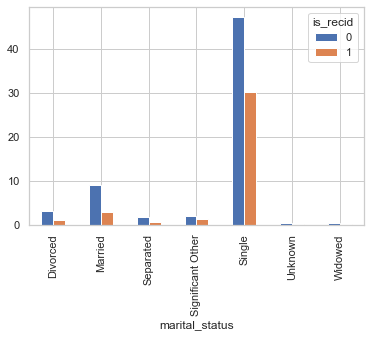

In [11]:
percentage = (pd.pivot_table(data = factor[['marital_status', 'is_recid']], index = 'marital_status', columns = 'is_recid', aggfunc = len, fill_value = 0)/len(factor)).mul(100)
print(percentage)
percentage.plot(kind = 'bar')

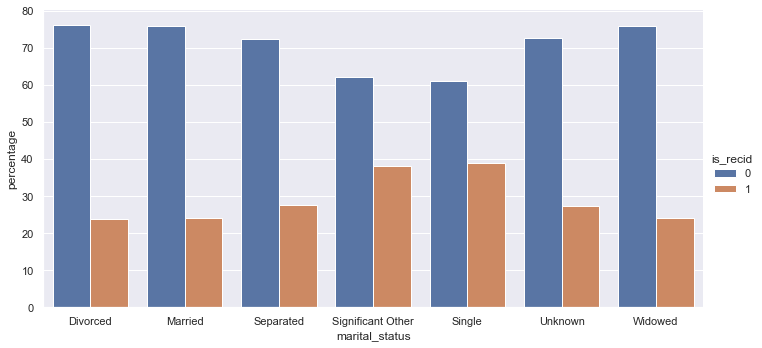

In [12]:
percentage = factor[['marital_status', 'is_recid']].groupby('marital_status')['is_recid'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.set(rc={'figure.figsize':(5,10)})
sns.catplot(data=percentage, x = 'marital_status', kind = 'bar', y = 'percentage', hue = 'is_recid', aspect = 2)

#### 2.4 charge degree

Since the charge degrees are also highly biased, only the one owns more than 1% of the data will be anlyzed for significant factor. The felony (F1, F2, F3, F1 is the most serious) and the misdemeanor (M1, M2, M1 is more serious) are the one that dominates the dataset. Interestingly, on this dataset, if we sort the charge degree with level of seriousness (F1,F2,F3,M1,M2, from more to less serious), it distributes like a normal distribution, where most of the data lies near the middle (F3, M1), and less of them lies at margin, which counters a possible thought that the less serious the crime is, the more people are recorded and committed. This could happened because of the fact that the less serious crime could be settled out of the court, or because the collection and the record of the data have an unknown threshold that diminish the number of less serious charge degree in the dataset. 

If we look at the second figure, the F1 have the lowest rate of recidivism, and it could simply because their criminal behaviors are too serious and have to kept in prison for a much longer time. The rest of the felony, F2 and F3 owns a higher rate of recidivism than misdemeanor, M1 and M2. Therefore, we can make a hypothesis that felony have a higher rate of recidivism than misdemeanor, and could verify it in section 3. 

is_recid                 0          1
c_charge_degree                      
(CO3)             0.000000   0.016982
(CT)              0.008491   0.000000
(F1)              1.519912   0.492485
(F2)              5.570179   3.226628
(F3)             32.427613  21.151397
(F5)              0.059438   0.000000
(F6)              0.093402   0.000000
(F7)              0.832130   0.382101
(M1)             17.619088   7.854292
(M2)              5.094676   2.632249
(MO3)             0.500976   0.229260
(NI0)             0.033965   0.033965
(TCX)             0.008491   0.000000
(X)               0.008491   0.000000


<AxesSubplot:xlabel='c_charge_degree'>

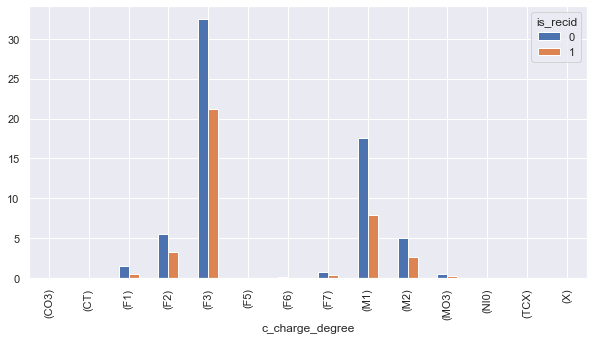

In [13]:
percentage = (pd.pivot_table(data = factor[['c_charge_degree', 'is_recid']], index = 'c_charge_degree', columns = 'is_recid', aggfunc = len, fill_value = 0)/len(factor)).mul(100)
print(percentage)
percentage.plot(kind = 'bar', figsize = (10,5))

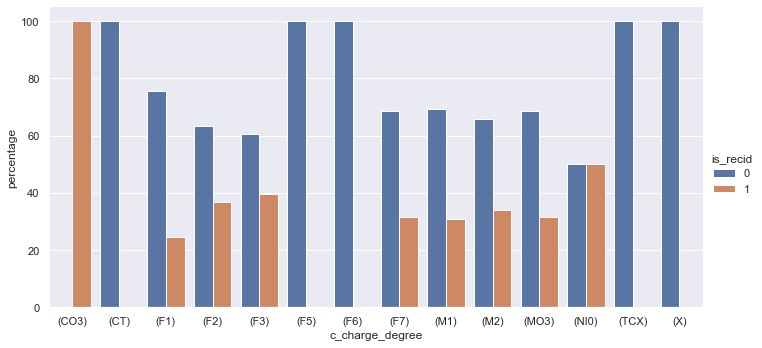

In [14]:
percentage = factor[['c_charge_degree', 'is_recid']].groupby('c_charge_degree')['is_recid'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.set(rc={'figure.figsize':(5,10)})
sns.catplot(data=percentage, x = 'c_charge_degree', kind = 'bar', y = 'percentage', hue = 'is_recid', aspect = 2)

#### 2.5 Decile Score

As we can see, as decile score increases, the number of people decreases but not the number of recidivists, meaning an increasing rate of recidivism. The observation indicates the COMPAS score of recidivism is effective in determining recidivism. We can set 5 as the threshold and run the hypothesis test later at section 3. 

is_recid              0         1
decile_score                     
-1             0.084911  0.016982
 1            17.347372  3.320031
 2             9.705358  3.277575
 3             7.141038  3.184173
 4             6.461747  3.727605
 5             5.256007  3.549291
 6             4.644646  3.905918
 7             4.092723  3.922901
 8             3.353995  3.829498
 9             3.345504  4.109705
 10            2.377515  3.345504


<AxesSubplot:xlabel='decile_score'>

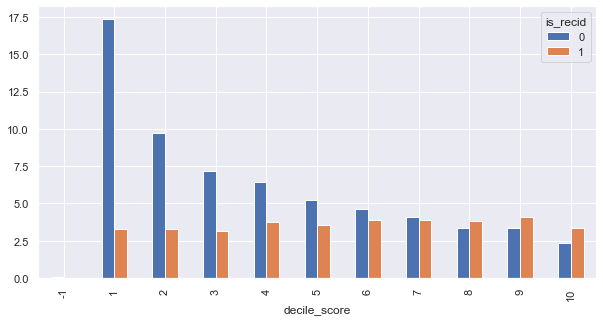

In [15]:
percentage = (pd.pivot_table(data = factor[['decile_score', 'is_recid']], index = 'decile_score', columns = 'is_recid', aggfunc = len, fill_value = 0)/len(factor)).mul(100)
print(percentage)
percentage.plot(kind = 'bar', figsize = (10,5))

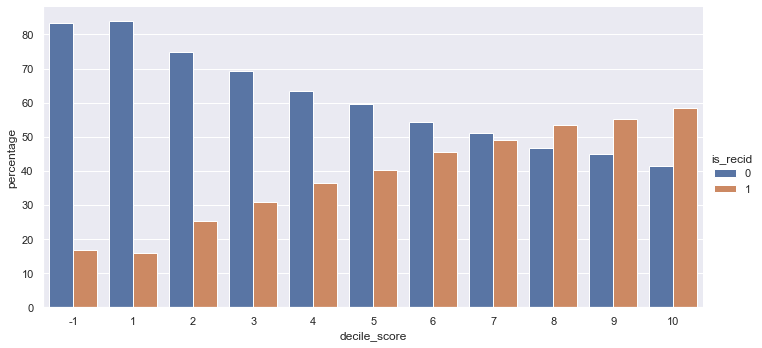

In [16]:
percentage = factor[['decile_score', 'is_recid']].groupby('decile_score')['is_recid'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.set(rc={'figure.figsize':(5,10)})
sns.catplot(data=percentage, x = 'decile_score', kind = 'bar', y = 'percentage', hue = 'is_recid', aspect = 2)

#### 2.6 Race

As we can see, the african american and the caucacian dominate the dataset with 50% and 33% respectively. If we turn to recidivism, the african american have a higher rate than the others except for native american, which only takes for less than 1% or the data. The native american could be further investigated but not in this dataset for its lack of number of data. Since the african american owns 50% of the data and they have a higher rate of recidivism, it could be a candidate for hypothesis test on affecting recidivism on section 3.

is_recid                  0          1
race                                  
African-American  29.200985  21.711811
Asian              0.365118   0.101894
Caucasian         23.588350  10.206334
Hispanic           6.453256   2.530356
Native American    0.195296   0.127367
Other              4.007812   1.511421


<AxesSubplot:xlabel='race'>

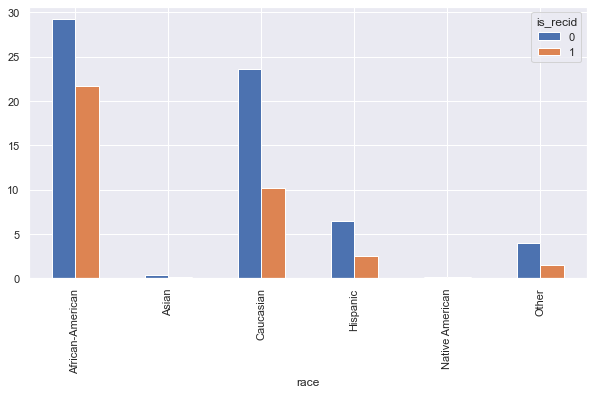

In [17]:
percentage = (pd.pivot_table(data = factor[['race', 'is_recid']], index = 'race', columns = 'is_recid', aggfunc = len, fill_value = 0)/len(factor)).mul(100)
print(percentage)
percentage.plot(kind = 'bar', figsize = (10,5))

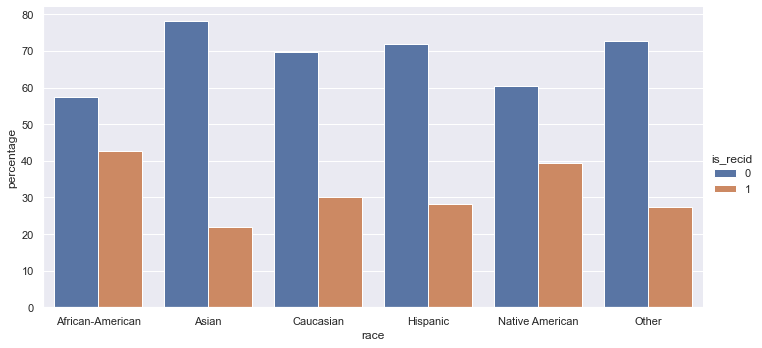

In [18]:
percentage = factor[['race', 'is_recid']].groupby('race')['is_recid'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.set(rc={'figure.figsize':(5,10)})
sns.catplot(data=percentage, x = 'race', kind = 'bar', y = 'percentage', hue = 'is_recid', aspect = 2)

### 3. Hypothesis test on significant factors

#### 3.1 Male

Null hypothesis: Probability of recidivism of male is not higher than female.

H0 : Pr{sex = male} <= Pr{sex = female}

Since p value is extremely low, we can reject the null hypothesis for over a 99.9% confidence level and determine that male has a higher probability of recidivism, hence a significant factor. Also, the 95% confident interval of male and female are 37.5%-39.5% and 25.2%-28.8% respectively, over a 10% gap of the two groups. 

In [25]:
control = factor[factor['sex'] == 'Male']['is_recid']
treat = factor[factor['sex'] == 'Female']['is_recid']

n_sample = [len(control), len(treat)]
n_success = [control.sum(), treat.sum()]

z_stat, p_val = proportions_ztest(n_success, n_sample)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(n_success, nobs=n_sample, alpha=0.05)

print(f'Recidivism rate for control group: {n_success[0]/n_sample[0]:.3f}')
print(f'Recidivism rate for treatment group: {n_success[1]/n_sample[1]:.3f}')
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_val:.4f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Recidivism rate for control group: 0.385
Recidivism rate for treatment group: 0.270
z statistic: 10.32
p-value: 0.0000
ci 95% for control group: [0.375, 0.395]
ci 95% for treatment group: [0.252, 0.288]


#### 3.2 Age less than 35

H0: Pr{age<=35} <= Pr{age>35}

Since a low p value, H0 is rejected and people under 35 have a higher probability of recidivism. Their 95% confident interval are 40.8%-43% for under 35 and 25.8%-28.4% for over 35.

In [26]:
control = factor[factor['age'] <= 35]['is_recid']
treat = factor[factor['age'] > 35]['is_recid']

n_sample = [len(control), len(treat)]
n_success = [control.sum(), treat.sum()]

z_stat, p_val = proportions_ztest(n_success, n_sample)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(n_success, nobs=n_sample, alpha=0.05)

print(f'Recidivism rate for control group: {n_success[0]/n_sample[0]:.3f}')
print(f'Recidivism rate for treatment group: {n_success[1]/n_sample[1]:.3f}')
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_val:.4f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Recidivism rate for control group: 0.419
Recidivism rate for treatment group: 0.271
z statistic: 16.26
p-value: 0.0000
ci 95% for control group: [0.408, 0.430]
ci 95% for treatment group: [0.258, 0.284]


#### 3.3 Single

H0: Pr{single} <= Pr{not single}

Again, a low p value means Pr{single} > Pr{not single} and the 95% confidence interval of single is 10% higher than that is not. 

In [27]:
control = factor[factor['marital_status'] == 'Single']['is_recid']
treat = factor[factor['marital_status'] != 'Single']['is_recid']

n_sample = [len(control), len(treat)]
n_success = [control.sum(), treat.sum()]

z_stat, p_val = proportions_ztest(n_success, n_sample)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(n_success, nobs=n_sample, alpha=0.05)

print(f'Recidivism rate for control group: {n_success[0]/n_sample[0]:.3f}')
print(f'Recidivism rate for treatment group: {n_success[1]/n_sample[1]:.3f}')
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_val:.4f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Recidivism rate for control group: 0.390
Recidivism rate for treatment group: 0.265
z statistic: 11.84
p-value: 0.0000
ci 95% for control group: [0.380, 0.400]
ci 95% for treatment group: [0.248, 0.282]


#### 3.4 Felony

H0 : Pr{charge degree is felony} <= Pr{charge degree is other}

The result of hypothesis test still confirms that for a 99.9% confidenct level, the people charged by the level of felony has a higher probability of recidivism. However, they only have a 7% higher probability to recidivate, slighly less than the other control group. 


In [32]:
control = factor[factor['c_charge_degree'].isin(['(F1)', '(F2)', '(F3)'])]['is_recid']
treat = factor[-factor['c_charge_degree'].isin(['(F1)', '(F2)', '(F3)'])]['is_recid']

n_sample = [len(control), len(treat)]
n_success = [control.sum(), treat.sum()]

z_stat, p_val = proportions_ztest(n_success, n_sample)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(n_success, nobs=n_sample, alpha=0.05)

print(f'Recidivism rate for control group: {n_success[0]/n_sample[0]:.3f}')
print(f'Recidivism rate for treatment group: {n_success[1]/n_sample[1]:.3f}')
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_val:.4f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Recidivism rate for control group: 0.386
Recidivism rate for treatment group: 0.318
z statistic: 7.40
p-value: 0.0000
ci 95% for control group: [0.375, 0.397]
ci 95% for treatment group: [0.304, 0.332]


#### 3.5 COMPAS Score more than 5

H0 : Pr{COMPAS decile score < 5} <= Pr{COMPAS decile score >= 5}

Since the COMPAS decile score could be see as an ensembled feature, which directly shows the probability of recidivism for an individual, it is not surprising that people with lower score significantly have a lower rate of recidivism. Hence, the objective of this subsection is to verify how accurate they COMPAS did. 

In [33]:
control = factor[factor['decile_score']>=5]['is_recid']
treat = factor[factor['decile_score']<5]['is_recid']

n_sample = [len(control), len(treat)]
n_success = [control.sum(), treat.sum()]

z_stat, p_val = proportions_ztest(n_success, n_sample)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(n_success, nobs=n_sample, alpha=0.05)

print(f'Recidivism rate for control group: {n_success[0]/n_sample[0]:.3f}')
print(f'Recidivism rate for treatment group: {n_success[1]/n_sample[1]:.3f}')
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {p_val:.4f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

Recidivism rate for control group: 0.496
Recidivism rate for treatment group: 0.249
z statistic: 27.71
p-value: 0.0000
ci 95% for control group: [0.482, 0.509]
ci 95% for treatment group: [0.239, 0.260]
